***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-2.1)** From coarse-to-Fine slowly decrease the dimension. i.e. 32D>16D>8D (Coarse>Medium>FINE), While keeping the primary capsule dimension same as original ($P_{capsule} = 8D$). Training with $L_{cons}$
    

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD_2\Training_and_Analysis\4_CIFAR-100
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "4" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  4
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('4_CIFAR_100/HD_CapsNet/HD_CapsNet_WO-SC')

FOLDER CREATED =  ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss


# Import Dataset : CIFAR-100

In [5]:
dataset = datasets.CIFAR100(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR100(version = 'reduce') # importing CIFAR10 Dataset


CIFAR-100 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
coarse_to_medium_array = np.zeros(shape=[number_of_classes_c,number_of_classes_m], dtype=np.int32)
medium_to_fine_array = np.zeros(shape=[number_of_classes_m,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

m_id = np.argmax(dataset['y_train_medium'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_test_medium'])):
    coarse_to_medium_array[c_id[x]][m_id[x]] = 1
    
for x in range(len(dataset['y_test_fine'])):
    medium_to_fine_array[m_id[x]][f_id[x]] = 1

Matrix_coarse_to_medium_OneHot = tf.constant(coarse_to_medium_array, dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(medium_to_fine_array, dtype=tf.float32)

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,tree: Tree,C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=number_of_classes_m)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=number_of_classes_f)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Model Architecture

In [11]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_medium_class = number_of_classes_m
    no_fine_class = number_of_classes_f

    PCap_n_dims = 8

    SCap_f_dims = 8
    SCap_m_dims = 16
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims),
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_c)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
                              dataset['tree']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [12]:
model = get_compiled_model()

In [13]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.cast (TFOpLambda)           (None,)              0           ['tf.math.argmax_4[0][0]']       
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 1)            0           ['tf.math.reduce_sum_2[0][0]']   
                                                                                                  
 tf.math.argmax (TFOpLambda)    (None,)              0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.argmax_1 (TFOpLambda)  (None,)              0           ['prediction_medium[0][0]']      
                                                                                                  
 tf.math.argmax_5 (TFOpLambda)  (None,)              0           ['input_ym[0][0]']               
          

 da)                                                                                              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.math.maximum_4 (TFOpLambda)  (None, 100)         0           ['tf.math.subtract_10[0][0]']    
                                                                                                  
 tf.math.subtract_12 (TFOpLambd  (None, 100)         0           ['input_yf[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.math.m

                                                                                                  
 tf.math.multiply_4 (TFOpLambda  (None,)             0           ['tf.math.abs_2[0][0]',          
 )                                                                'tf.math.abs[0][0]']            
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 100)          0           ['tf.math.multiply_16[0][0]',    
                                                                  'tf.math.multiply_18[0][0]']    
                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None,)              0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.abs_1 (TFOpLambda)     (None,)              0           ['tf.math.subtract_1[0][0]']     
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.5243 - prediction_coarse_accuracy: 0.4603 - prediction_medium_accuracy: 0.1832 - prediction_fine_accuracy: 0.0152
  • Coarse Accuracy = 46.03% | Val_Accuracy = 52.83% | LossWeight = 0.36 
  • Medium Accuracy = 18.32% | Val_Accuracy = 28.49% | LossWeight = 0.49 
  • Fine   Accuracy = 1.52% | Val_Accuracy = 1.71% | LossWeight = 0.15 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.01710, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 69s 77ms/step - loss: 0.5243 - prediction_coarse_accuracy: 0.4603 - prediction_medium_accuracy: 0.1832 - prediction_fine_accuracy: 0.0152 - val_loss: 0.4381 - val_prediction_coarse_accuracy: 0.5283 - val_prediction_medium_accuracy: 0.2849 - val_prediction_fine_accuracy: 0.0171 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.3620 - prediction_coarse_accuracy:

Epoch 18/100
781/781 [==============================] - ETA: 0s - loss: 0.1359 - prediction_coarse_accuracy: 0.9146 - prediction_medium_accuracy: 0.8696 - prediction_fine_accuracy: 0.2701
  • Coarse Accuracy = 91.46% | Val_Accuracy = 84.04% | LossWeight = 0.23 
  • Medium Accuracy = 86.96% | Val_Accuracy = 73.88% | LossWeight = 0.31 
  • Fine   Accuracy = 27.01% | Val_Accuracy = 23.61% | LossWeight = 0.46 

Epoch 18: val_prediction_fine_accuracy improved from 0.23600 to 0.23610, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 68s 87ms/step - loss: 0.1359 - prediction_coarse_accuracy: 0.9146 - prediction_medium_accuracy: 0.8696 - prediction_fine_accuracy: 0.2701 - val_loss: 0.1508 - val_prediction_coarse_accuracy: 0.8404 - val_prediction_medium_accuracy: 0.7388 - val_prediction_fine_accuracy: 0.2361 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.1319 - prediction_coar

Epoch 27/100
781/781 [==============================] - ETA: 0s - loss: 0.1155 - prediction_coarse_accuracy: 0.9401 - prediction_medium_accuracy: 0.9163 - prediction_fine_accuracy: 0.3506
  • Coarse Accuracy = 94.01% | Val_Accuracy = 83.49% | LossWeight = 0.21 
  • Medium Accuracy = 91.63% | Val_Accuracy = 73.42% | LossWeight = 0.26 
  • Fine   Accuracy = 35.06% | Val_Accuracy = 30.23% | LossWeight = 0.53 

Epoch 27: val_prediction_fine_accuracy improved from 0.29590 to 0.30230, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 70s 90ms/step - loss: 0.1155 - prediction_coarse_accuracy: 0.9401 - prediction_medium_accuracy: 0.9163 - prediction_fine_accuracy: 0.3506 - val_loss: 0.1477 - val_prediction_coarse_accuracy: 0.8349 - val_prediction_medium_accuracy: 0.7342 - val_prediction_fine_accuracy: 0.3023 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.1144 - prediction_coar

Epoch 36/100
781/781 [==============================] - ETA: 0s - loss: 0.1051 - prediction_coarse_accuracy: 0.9510 - prediction_medium_accuracy: 0.9345 - prediction_fine_accuracy: 0.4209
  • Coarse Accuracy = 95.10% | Val_Accuracy = 85.09% | LossWeight = 0.20 
  • Medium Accuracy = 93.45% | Val_Accuracy = 76.04% | LossWeight = 0.24 
  • Fine   Accuracy = 42.09% | Val_Accuracy = 34.67% | LossWeight = 0.56 

Epoch 36: val_prediction_fine_accuracy improved from 0.34540 to 0.34670, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 64s 82ms/step - loss: 0.1051 - prediction_coarse_accuracy: 0.9510 - prediction_medium_accuracy: 0.9345 - prediction_fine_accuracy: 0.4209 - val_loss: 0.1357 - val_prediction_coarse_accuracy: 0.8509 - val_prediction_medium_accuracy: 0.7604 - val_prediction_fine_accuracy: 0.3467 - lr: 2.6352e-04
Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.1047 - prediction_coar

Epoch 54/100
781/781 [==============================] - ETA: 0s - loss: 0.0972 - prediction_coarse_accuracy: 0.9551 - prediction_medium_accuracy: 0.9419 - prediction_fine_accuracy: 0.4834
  • Coarse Accuracy = 95.51% | Val_Accuracy = 85.76% | LossWeight = 0.21 
  • Medium Accuracy = 94.19% | Val_Accuracy = 76.54% | LossWeight = 0.24 
  • Fine   Accuracy = 48.34% | Val_Accuracy = 39.13% | LossWeight = 0.55 

Epoch 54: val_prediction_fine_accuracy improved from 0.38930 to 0.39130, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 55s 70ms/step - loss: 0.0972 - prediction_coarse_accuracy: 0.9551 - prediction_medium_accuracy: 0.9419 - prediction_fine_accuracy: 0.4834 - val_loss: 0.1287 - val_prediction_coarse_accuracy: 0.8576 - val_prediction_medium_accuracy: 0.7654 - val_prediction_fine_accuracy: 0.3913 - lr: 1.0467e-04
Epoch 55/100
781/781 [==============================] - ETA: 0s - loss: 0.0971 - prediction_coar

Epoch 63/100
781/781 [==============================] - ETA: 0s - loss: 0.0948 - prediction_coarse_accuracy: 0.9576 - prediction_medium_accuracy: 0.9458 - prediction_fine_accuracy: 0.5018
  • Coarse Accuracy = 95.76% | Val_Accuracy = 86.09% | LossWeight = 0.20 
  • Medium Accuracy = 94.58% | Val_Accuracy = 77.07% | LossWeight = 0.24 
  • Fine   Accuracy = 50.18% | Val_Accuracy = 40.22% | LossWeight = 0.56 

Epoch 63: val_prediction_fine_accuracy improved from 0.40040 to 0.40220, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 53s 68ms/step - loss: 0.0948 - prediction_coarse_accuracy: 0.9576 - prediction_medium_accuracy: 0.9458 - prediction_fine_accuracy: 0.5018 - val_loss: 0.1277 - val_prediction_coarse_accuracy: 0.8609 - val_prediction_medium_accuracy: 0.7707 - val_prediction_fine_accuracy: 0.4022 - lr: 6.5971e-05
Epoch 64/100
781/781 [==============================] - ETA: 0s - loss: 0.0954 - prediction_coar

Epoch 72/100
781/781 [==============================] - ETA: 0s - loss: 0.0949 - prediction_coarse_accuracy: 0.9580 - prediction_medium_accuracy: 0.9484 - prediction_fine_accuracy: 0.5151
  • Coarse Accuracy = 95.80% | Val_Accuracy = 86.06% | LossWeight = 0.21 
  • Medium Accuracy = 94.84% | Val_Accuracy = 77.50% | LossWeight = 0.23 
  • Fine   Accuracy = 51.51% | Val_Accuracy = 41.14% | LossWeight = 0.56 

Epoch 72: val_prediction_fine_accuracy did not improve from 0.41180
781/781 [==============================] - 87s 111ms/step - loss: 0.0949 - prediction_coarse_accuracy: 0.9580 - prediction_medium_accuracy: 0.9484 - prediction_fine_accuracy: 0.5151 - val_loss: 0.1276 - val_prediction_coarse_accuracy: 0.8606 - val_prediction_medium_accuracy: 0.7750 - val_prediction_fine_accuracy: 0.4114 - lr: 4.1578e-05
Epoch 73/100
781/781 [==============================] - ETA: 0s - loss: 0.0951 - prediction_coarse_accuracy: 0.9565 - prediction_medium_accuracy: 0.9450 - prediction_fine_accuracy: 0

781/781 [==============================] - 66s 85ms/step - loss: 0.0944 - prediction_coarse_accuracy: 0.9575 - prediction_medium_accuracy: 0.9443 - prediction_fine_accuracy: 0.5201 - val_loss: 0.1265 - val_prediction_coarse_accuracy: 0.8628 - val_prediction_medium_accuracy: 0.7736 - val_prediction_fine_accuracy: 0.4178 - lr: 1.6515e-05
Epoch 91/100
781/781 [==============================] - ETA: 0s - loss: 0.0933 - prediction_coarse_accuracy: 0.9592 - prediction_medium_accuracy: 0.9485 - prediction_fine_accuracy: 0.5245
  • Coarse Accuracy = 95.92% | Val_Accuracy = 86.26% | LossWeight = 0.21 
  • Medium Accuracy = 94.85% | Val_Accuracy = 77.19% | LossWeight = 0.23 
  • Fine   Accuracy = 52.45% | Val_Accuracy = 41.71% | LossWeight = 0.56 

Epoch 91: val_prediction_fine_accuracy did not improve from 0.41810
781/781 [==============================] - 67s 86ms/step - loss: 0.0933 - prediction_coarse_accuracy: 0.9592 - prediction_medium_accuracy: 0.9485 - prediction_fine_accuracy: 0.5245 - 

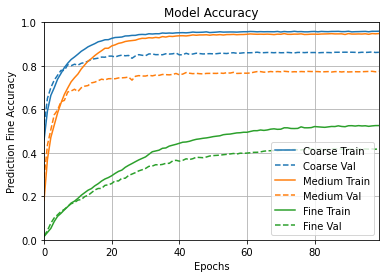

In [17]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

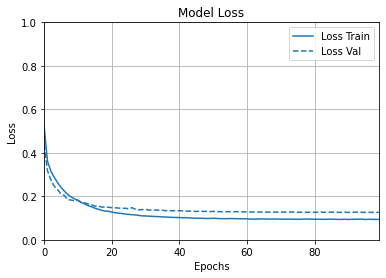

In [18]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 8s 18ms/step - loss: 0.3336 - prediction_coarse_loss: 0.1060 - prediction_medium_loss: 0.1723 - prediction_fine_loss: 0.4846 - prediction_coarse_accuracy: 0.8623 - prediction_medium_accuracy: 0.7753 - prediction_fine_accuracy: 0.4182
1. loss ==> 0.3336273729801178
2. prediction_coarse_loss ==> 0.10595320910215378
3. prediction_medium_loss ==> 0.17230045795440674
4. prediction_fine_loss ==> 0.48463839292526245
5. prediction_coarse_accuracy ==> 0.8622999787330627
6. prediction_medium_accuracy ==> 0.7753000259399414
7. prediction_fine_accuracy ==> 0.41819998621940613
313/313 [==============================] - 5s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

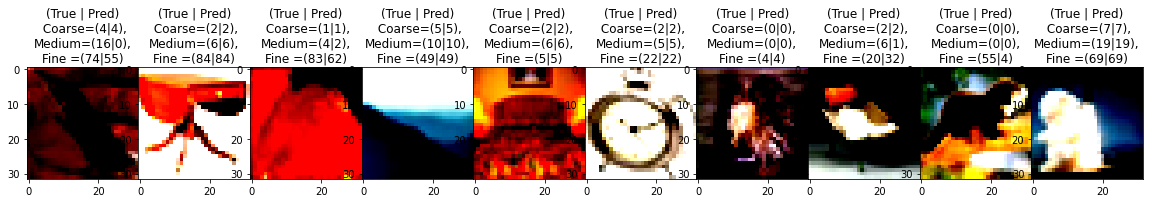

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 713   16   22   37  175   12   11   14]
 [   8 1356   32   39   43   16    0    6]
 [   4   21 1380   28   23   13    8   23]
 [  20   28   30  797  110    2    3   10]
 [  97   24   46   95 2190   11   13   24]
 [  12   29   24    8   27  870    0   30]
 [   6   10   16   13   31    0  422    2]
 [   8    3   31   11   23   29    0  895]]

  • MEDIUM LEVEL 
[[317  28   0   1   1   7   2   7  15   2   4  14  25  15   8  29  18   2
    1   4]
 [ 35 355  11   5   5   3   2   5   3   3   7   1  10  11   7  21   7   0
    4   5]
 [  0   4 446   4  15   1   2  14   3   1   1   1   0   2   0   1   2   2
    0   1]
 [  0   1   4 407  11  36   9   4   1   1   0   1   0   4   6   4   0   0
    4   7]
 [  0   1  18  12 417   8   1  10   3   1   2   3   3  11   0   5   4   1
    0   0]
 [  0   3   2  36   4 391  25   3   1   4   3   0   3   9   5   3   1   0
    2   5]
 [  1   3   1  15   2  22 432   1   0   5   2   0   1   4   1   1   0   1
    6   2]


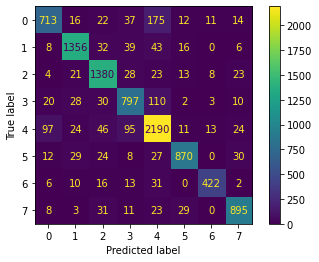

              precision    recall  f1-score   support

           0    0.82143   0.71300   0.76338      1000
           1    0.91190   0.90400   0.90793      1500
           2    0.87287   0.92000   0.89581      1500
           3    0.77529   0.79700   0.78600      1000
           4    0.83524   0.87600   0.85513      2500
           5    0.91291   0.87000   0.89094      1000
           6    0.92341   0.84400   0.88192       500
           7    0.89143   0.89500   0.89321      1000

    accuracy                        0.86230     10000
   macro avg    0.86806   0.85237   0.85929     10000
weighted avg    0.86280   0.86230   0.86179     10000


  • MEDIUM LEVEL 


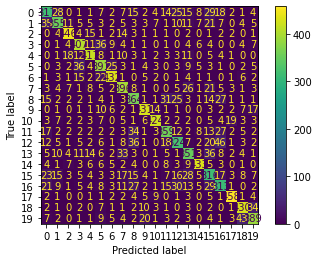

              precision    recall  f1-score   support

           0    0.67880   0.63400   0.65564       500
           1    0.78022   0.71000   0.74346       500
           2    0.87280   0.89200   0.88229       500
           3    0.78269   0.81400   0.79804       500
           4    0.83068   0.83400   0.83234       500
           5    0.72140   0.78200   0.75048       500
           6    0.85375   0.86400   0.85885       500
           7    0.74576   0.79200   0.76819       500
           8    0.69070   0.72800   0.70886       500
           9    0.86373   0.86200   0.86286       500
          10    0.88889   0.84800   0.86796       500
          11    0.76383   0.71800   0.74021       500
          12    0.69828   0.64800   0.67220       500
          13    0.69368   0.70200   0.69781       500
          14    0.89278   0.86600   0.87919       500
          15    0.58845   0.63200   0.60945       500
          16    0.64403   0.62600   0.63489       500
          17    0.91235   0

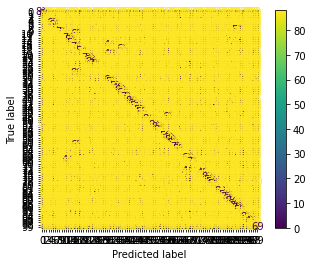

              precision    recall  f1-score   support

           0    0.67500   0.81000   0.73636       100
           1    0.78947   0.60000   0.68182       100
           2    0.43590   0.17000   0.24460       100
           3    0.37500   0.09000   0.14516       100
           4    0.36364   0.40000   0.38095       100
           5    0.41333   0.62000   0.49600       100
           6    0.60550   0.66000   0.63158       100
           7    0.00000   0.00000   0.00000       100
           8    0.00000   0.00000   0.00000       100
           9    0.64103   0.75000   0.69124       100
          10    0.00000   0.00000   0.00000       100
          11    0.23214   0.13000   0.16667       100
          12    0.32759   0.76000   0.45783       100
          13    0.36957   0.51000   0.42857       100
          14    0.33540   0.54000   0.41379       100
          15    0.00000   0.00000   0.00000       100
          16    0.19388   0.76000   0.30894       100
          17    0.00000   0

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [22]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.6839866666666666 
Hierarchical Recall = 0.6961333333333332 
Hierarchical F1-Score = 0.6887805555555555 
Consistency =  0.9192 
Exact Match =  0.4097


# Training Again

In [23]:
model_save_dir = str(directory+'/trained_model_2.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.1227 - prediction_coarse_accuracy: 0.9175 - prediction_medium_accuracy: 0.8764 - prediction_fine_accuracy: 0.4325
  • Coarse Accuracy = 91.75% | Val_Accuracy = 82.94% | LossWeight = 0.25 
  • Medium Accuracy = 87.64% | Val_Accuracy = 72.35% | LossWeight = 0.34 
  • Fine   Accuracy = 43.25% | Val_Accuracy = 36.31% | LossWeight = 0.41 

Epoch 1: val_prediction_fine_accuracy did not improve from 0.41820
781/781 [==============================] - 54s 69ms/step - loss: 0.1227 - prediction_coarse_accuracy: 0.9175 - prediction_medium_accuracy: 0.8764 - prediction_fine_accuracy: 0.4325 - val_loss: 0.1471 - val_prediction_coarse_accuracy: 0.8294 - val_prediction_medium_accuracy: 0.7235 - val_prediction_fine_accuracy: 0.3631 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1334 - prediction_coarse_accuracy: 0.9057 - prediction_medium_accuracy: 0.8632 - prediction_fine_accuracy: 0.4215
  

Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.1078 - prediction_coarse_accuracy: 0.9386 - prediction_medium_accuracy: 0.9141 - prediction_fine_accuracy: 0.5248
  • Coarse Accuracy = 93.86% | Val_Accuracy = 83.99% | LossWeight = 0.25 
  • Medium Accuracy = 91.41% | Val_Accuracy = 74.59% | LossWeight = 0.31 
  • Fine   Accuracy = 52.48% | Val_Accuracy = 43.43% | LossWeight = 0.44 

Epoch 10: val_prediction_fine_accuracy improved from 0.42980 to 0.43430, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 54s 69ms/step - loss: 0.1078 - prediction_coarse_accuracy: 0.9386 - prediction_medium_accuracy: 0.9141 - prediction_fine_accuracy: 0.5248 - val_loss: 0.1384 - val_prediction_coarse_accuracy: 0.8399 - val_prediction_medium_accuracy: 0.7459 - val_prediction_fine_accuracy: 0.4343 - lr: 0.0010
Epoch 11/100
781/781 [==============================] - ETA: 0s - loss: 0.1115 - prediction_coarse_a

Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.0982 - prediction_coarse_accuracy: 0.9477 - prediction_medium_accuracy: 0.9299 - prediction_fine_accuracy: 0.6104
  • Coarse Accuracy = 94.77% | Val_Accuracy = 84.93% | LossWeight = 0.25 
  • Medium Accuracy = 92.99% | Val_Accuracy = 75.61% | LossWeight = 0.31 
  • Fine   Accuracy = 61.04% | Val_Accuracy = 48.16% | LossWeight = 0.44 

Epoch 19: val_prediction_fine_accuracy did not improve from 0.48610
781/781 [==============================] - 63s 81ms/step - loss: 0.0982 - prediction_coarse_accuracy: 0.9477 - prediction_medium_accuracy: 0.9299 - prediction_fine_accuracy: 0.6104 - val_loss: 0.1329 - val_prediction_coarse_accuracy: 0.8493 - val_prediction_medium_accuracy: 0.7561 - val_prediction_fine_accuracy: 0.4816 - lr: 6.3025e-04
Epoch 20/100
781/781 [==============================] - ETA: 0s - loss: 0.1040 - prediction_coarse_accuracy: 0.9385 - prediction_medium_accuracy: 0.9158 - prediction_fine_accuracy: 0.

Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.0899 - prediction_coarse_accuracy: 0.9559 - prediction_medium_accuracy: 0.9421 - prediction_fine_accuracy: 0.6824
  • Coarse Accuracy = 95.59% | Val_Accuracy = 85.88% | LossWeight = 0.26 
  • Medium Accuracy = 94.21% | Val_Accuracy = 76.98% | LossWeight = 0.31 
  • Fine   Accuracy = 68.24% | Val_Accuracy = 53.41% | LossWeight = 0.44 

Epoch 28: val_prediction_fine_accuracy improved from 0.52750 to 0.53410, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 110s 140ms/step - loss: 0.0899 - prediction_coarse_accuracy: 0.9559 - prediction_medium_accuracy: 0.9421 - prediction_fine_accuracy: 0.6824 - val_loss: 0.1228 - val_prediction_coarse_accuracy: 0.8588 - val_prediction_medium_accuracy: 0.7698 - val_prediction_fine_accuracy: 0.5341 - lr: 3.9721e-04
Epoch 29/100
781/781 [==============================] - ETA: 0s - loss: 0.0891 - prediction_co

Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.0856 - prediction_coarse_accuracy: 0.9581 - prediction_medium_accuracy: 0.9460 - prediction_fine_accuracy: 0.7296
  • Coarse Accuracy = 95.81% | Val_Accuracy = 86.16% | LossWeight = 0.27 
  • Medium Accuracy = 94.60% | Val_Accuracy = 77.61% | LossWeight = 0.32 
  • Fine   Accuracy = 72.96% | Val_Accuracy = 55.29% | LossWeight = 0.41 

Epoch 37: val_prediction_fine_accuracy improved from 0.54740 to 0.55290, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 117s 149ms/step - loss: 0.0856 - prediction_coarse_accuracy: 0.9581 - prediction_medium_accuracy: 0.9460 - prediction_fine_accuracy: 0.7296 - val_loss: 0.1215 - val_prediction_coarse_accuracy: 0.8616 - val_prediction_medium_accuracy: 0.7761 - val_prediction_fine_accuracy: 0.5529 - lr: 2.5034e-04
Epoch 38/100
781/781 [==============================] - ETA: 0s - loss: 0.0859 - prediction_co

781/781 [==============================] - 108s 138ms/step - loss: 0.0852 - prediction_coarse_accuracy: 0.9577 - prediction_medium_accuracy: 0.9463 - prediction_fine_accuracy: 0.7560 - val_loss: 0.1226 - val_prediction_coarse_accuracy: 0.8619 - val_prediction_medium_accuracy: 0.7772 - val_prediction_fine_accuracy: 0.5586 - lr: 1.5778e-04
Epoch 47/100
781/781 [==============================] - ETA: 0s - loss: 0.0859 - prediction_coarse_accuracy: 0.9580 - prediction_medium_accuracy: 0.9473 - prediction_fine_accuracy: 0.7579
  • Coarse Accuracy = 95.80% | Val_Accuracy = 86.24% | LossWeight = 0.29 
  • Medium Accuracy = 94.73% | Val_Accuracy = 77.75% | LossWeight = 0.33 
  • Fine   Accuracy = 75.79% | Val_Accuracy = 56.05% | LossWeight = 0.39 

Epoch 47: val_prediction_fine_accuracy improved from 0.55860 to 0.56050, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 115s 147ms/step - loss: 0.0859 - prediction_coarse_

Epoch 56/100
781/781 [==============================] - ETA: 0s - loss: 0.0840 - prediction_coarse_accuracy: 0.9603 - prediction_medium_accuracy: 0.9492 - prediction_fine_accuracy: 0.7745
  • Coarse Accuracy = 96.03% | Val_Accuracy = 86.30% | LossWeight = 0.29 
  • Medium Accuracy = 94.92% | Val_Accuracy = 78.07% | LossWeight = 0.33 
  • Fine   Accuracy = 77.45% | Val_Accuracy = 56.20% | LossWeight = 0.38 

Epoch 56: val_prediction_fine_accuracy did not improve from 0.56330
781/781 [==============================] - 106s 135ms/step - loss: 0.0840 - prediction_coarse_accuracy: 0.9603 - prediction_medium_accuracy: 0.9492 - prediction_fine_accuracy: 0.7745 - val_loss: 0.1207 - val_prediction_coarse_accuracy: 0.8630 - val_prediction_medium_accuracy: 0.7807 - val_prediction_fine_accuracy: 0.5620 - lr: 9.4468e-05
Epoch 57/100
781/781 [==============================] - ETA: 0s - loss: 0.0842 - prediction_coarse_accuracy: 0.9608 - prediction_medium_accuracy: 0.9502 - prediction_fine_accuracy: 

781/781 [==============================] - 80s 103ms/step - loss: 0.0824 - prediction_coarse_accuracy: 0.9613 - prediction_medium_accuracy: 0.9509 - prediction_fine_accuracy: 0.7924 - val_loss: 0.1204 - val_prediction_coarse_accuracy: 0.8636 - val_prediction_medium_accuracy: 0.7816 - val_prediction_fine_accuracy: 0.5690 - lr: 3.7524e-05
Epoch 75/100
781/781 [==============================] - ETA: 0s - loss: 0.0835 - prediction_coarse_accuracy: 0.9608 - prediction_medium_accuracy: 0.9513 - prediction_fine_accuracy: 0.7879
  • Coarse Accuracy = 96.08% | Val_Accuracy = 86.45% | LossWeight = 0.30 
  • Medium Accuracy = 95.13% | Val_Accuracy = 78.03% | LossWeight = 0.33 
  • Fine   Accuracy = 78.79% | Val_Accuracy = 57.13% | LossWeight = 0.37 

Epoch 75: val_prediction_fine_accuracy improved from 0.56990 to 0.57130, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 73s 94ms/step - loss: 0.0835 - prediction_coarse_acc

781/781 [==============================] - 112s 144ms/step - loss: 0.0815 - prediction_coarse_accuracy: 0.9623 - prediction_medium_accuracy: 0.9517 - prediction_fine_accuracy: 0.7967 - val_loss: 0.1198 - val_prediction_coarse_accuracy: 0.8654 - val_prediction_medium_accuracy: 0.7813 - val_prediction_fine_accuracy: 0.5698 - lr: 1.4160e-05
Epoch 94/100
781/781 [==============================] - ETA: 0s - loss: 0.0814 - prediction_coarse_accuracy: 0.9638 - prediction_medium_accuracy: 0.9539 - prediction_fine_accuracy: 0.7955
  • Coarse Accuracy = 96.38% | Val_Accuracy = 86.66% | LossWeight = 0.29 
  • Medium Accuracy = 95.39% | Val_Accuracy = 78.15% | LossWeight = 0.33 
  • Fine   Accuracy = 79.55% | Val_Accuracy = 57.01% | LossWeight = 0.38 

Epoch 94: val_prediction_fine_accuracy did not improve from 0.57130
781/781 [==============================] - 102s 131ms/step - loss: 0.0814 - prediction_coarse_accuracy: 0.9638 - prediction_medium_accuracy: 0.9539 - prediction_fine_accuracy: 0.795

In [24]:
history_dict = history.history

(0.0, 1.0)

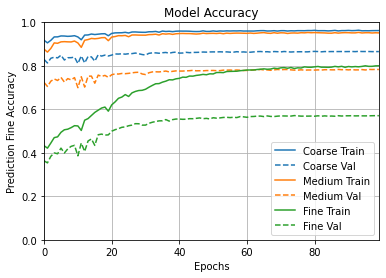

In [25]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

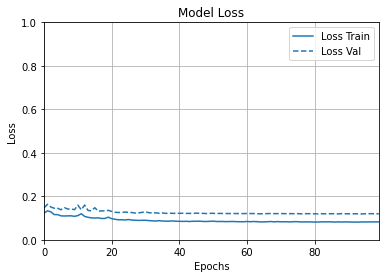

In [26]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [27]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 14s 34ms/step - loss: 0.2140 - prediction_coarse_loss: 0.1018 - prediction_medium_loss: 0.1649 - prediction_fine_loss: 0.3507 - prediction_coarse_accuracy: 0.8657 - prediction_medium_accuracy: 0.7833 - prediction_fine_accuracy: 0.5708
1. loss ==> 0.21399113535881042
2. prediction_coarse_loss ==> 0.10178210586309433
3. prediction_medium_loss ==> 0.16491176187992096
4. prediction_fine_loss ==> 0.35065603256225586
5. prediction_coarse_accuracy ==> 0.8657000064849854
6. prediction_medium_accuracy ==> 0.78329998254776
7. prediction_fine_accuracy ==> 0.5708000063896179
313/313 [==============================] - 8s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

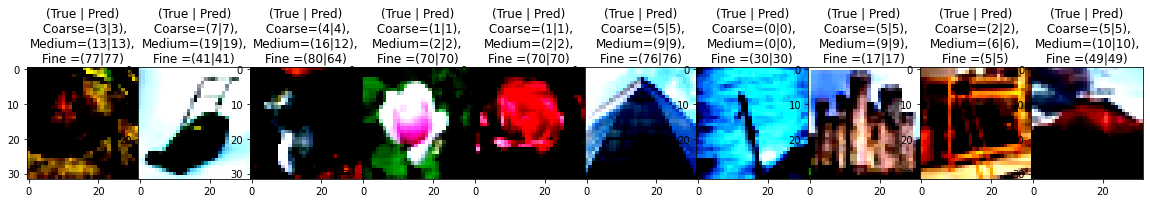

In [28]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 723   14   25   34  176   10   10    8]
 [   6 1364   26   39   40   20    1    4]
 [   5   24 1379   24   25   12   11   20]
 [  22   34   28  791  102    4    7   12]
 [  85   21   34   98 2221    7   12   22]
 [  10   26   22    7   34  867    1   33]
 [   8   12   11   12   32    0  423    2]
 [   8    4   33    8   30   28    0  889]]

  • MEDIUM LEVEL 
[[322  29   0   3   0   4   2   8  24   3   3  13  18  17   5  23  22   0
    2   2]
 [ 29 369   9   6   5   5   3   9   3   4   3   3   5   7   8  16  10   1
    4   1]
 [  0   2 455   2  12   2   1  12   2   1   1   0   0   6   1   1   0   1
    0   1]
 [  0   1   4 412  12  37   5   2   1   0   0   2   0   5   4   5   2   0
    3   5]
 [  1   1  25   8 417   9   0   6   3   2   1   3   1  13   1   4   5   0
    0   0]
 [  2   4   0  28   5 401  18   5   0   6   2   2   1  10   7   2   0   1
    1   5]
 [  0   1   0  12   2  25 429   2   2   4   2   0   2   3   4   2   0   1
    5   4]


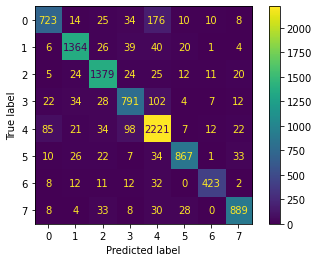

              precision    recall  f1-score   support

           0    0.83391   0.72300   0.77450      1000
           1    0.90994   0.90933   0.90964      1500
           2    0.88511   0.91933   0.90190      1500
           3    0.78085   0.79100   0.78589      1000
           4    0.83496   0.88840   0.86085      2500
           5    0.91456   0.86700   0.89014      1000
           6    0.90968   0.84600   0.87668       500
           7    0.89798   0.88900   0.89347      1000

    accuracy                        0.86570     10000
   macro avg    0.87087   0.85413   0.86163     10000
weighted avg    0.86621   0.86570   0.86518     10000


  • MEDIUM LEVEL 


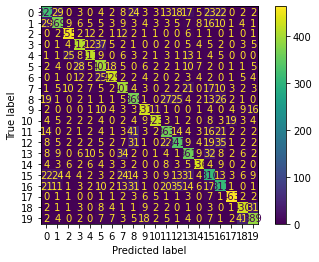

              precision    recall  f1-score   support

           0    0.69848   0.64400   0.67014       500
           1    0.77521   0.73800   0.75615       500
           2    0.87165   0.91000   0.89041       500
           3    0.82400   0.82400   0.82400       500
           4    0.85451   0.83400   0.84413       500
           5    0.72909   0.80200   0.76381       500
           6    0.88090   0.85800   0.86930       500
           7    0.73578   0.80200   0.76746       500
           8    0.67706   0.73800   0.70622       500
           9    0.85347   0.86200   0.85771       500
          10    0.92358   0.84600   0.88309       500
          11    0.74082   0.72600   0.73333       500
          12    0.73491   0.68200   0.70747       500
          13    0.69423   0.72200   0.70784       500
          14    0.88081   0.87200   0.87638       500
          15    0.60784   0.62000   0.61386       500
          16    0.65199   0.62200   0.63664       500
          17    0.91321   0

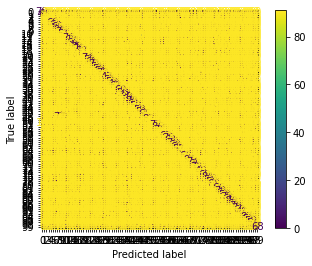

              precision    recall  f1-score   support

           0    0.75238   0.79000   0.77073       100
           1    0.89189   0.66000   0.75862       100
           2    0.46237   0.43000   0.44560       100
           3    0.57812   0.37000   0.45122       100
           4    0.50000   0.34000   0.40476       100
           5    0.53488   0.69000   0.60262       100
           6    0.76190   0.64000   0.69565       100
           7    0.55556   0.65000   0.59908       100
           8    0.50279   0.90000   0.64516       100
           9    0.92405   0.73000   0.81564       100
          10    0.35664   0.51000   0.41975       100
          11    0.40260   0.31000   0.35028       100
          12    0.62810   0.76000   0.68778       100
          13    0.52542   0.62000   0.56881       100
          14    0.54545   0.66000   0.59729       100
          15    0.56471   0.48000   0.51892       100
          16    0.66364   0.73000   0.69524       100
          17    0.80000   0

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [30]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.73863 
Hierarchical Recall = 0.7500333333333334 
Hierarchical F1-Score = 0.743088492063492 
Consistency =  0.9251 
Exact Match =  0.561
